<a href="https://colab.research.google.com/gist/roxdm/1e2af006862f4d25eeffc4dd6a564397/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Auto-Encoders
=========================
This code implements a Variation Auto-Encoder (VAE). If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118 #uncomment to enforce cuda 11.8

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm


%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
if os.path.exists('./training') == False:
  os.mkdir('./training')

Hyper-Parameters
----------------

In [5]:
batch_size = 3000     # batch size
latent_dim = 100      # latent-space dimension
middle_dim = 128      # size of the middle layer
learning_rate = 1e-3  # learning rate
max_epochs = 50       # maximum number of epochs
use_gpu = True        # using the GPU

Loading the Dataset
-------------------
As in the GAN example, we will be using the MNIST dataset. MNIST images show digits from 0-9 in 28x28 grayscale images.

In [ ]:

input_dim = 28**2

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

c:\Users\roxan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
2025-05-26 15:10:51.902915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 15:10:56.024611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os
import shutil
import tempfile
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator

c:\Users\roxan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


In [19]:

# image dimensions
input_dim = 64*64

from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)


C:\Users\roxan\AppData\Local\Temp\Mxt242\roxan_desktopastnsf4\var\log\xwin\tmptsv7890u


MedNIST.tar.gz: 59.0MB [00:02, 28.7MB/s]                            

2025-05-26 15:45:28,711 - INFO - Downloaded: C:\Users\roxan\AppData\Local\Temp\Mxt242\roxan_desktopastnsf4\var\log\xwin\tmptsv7890u\MedNIST.tar.gz


2025-05-26 15:45:28,835 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-26 15:45:28,836 - INFO - Writing into directory: C:\Users\roxan\AppData\Local\Temp\Mxt242\roxan_desktopastnsf4\var\log\xwin\tmptsv7890u.


Loading dataset: 100%|██████████| 47164/47164 [06:47<00:00, 115.76it/s]


In [20]:
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
test_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2025-05-26 15:53:41,125 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-26 15:53:41,126 - INFO - File exists: C:\Users\roxan\AppData\Local\Temp\Mxt242\roxan_desktopastnsf4\var\log\xwin\tmptsv7890u\MedNIST.tar.gz, skipped downloading.
2025-05-26 15:53:41,128 - INFO - Non-empty folder exists in C:\Users\roxan\AppData\Local\Temp\Mxt242\roxan_desktopastnsf4\var\log\xwin\tmptsv7890u\MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:51<00:00, 114.78it/s]


VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [21]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [22]:
class Q(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(Q, self).__init__()
    self.lin_middle = nn.Linear(input_dim, middle_dim, bias=True)
    self.lin_mu = nn.Linear(middle_dim, latent_dim, bias=True)
    self.lin_var = nn.Linear(middle_dim, latent_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_middle)
    init_weights(self.lin_mu)
    init_weights(self.lin_var)

  def forward(self, input):
    # forward
    middle = F.relu(self.lin_middle(input))
    z_mu = self.lin_mu(middle)
    z_var = self.lin_var(middle)
    return z_mu, z_var

We now model the reparametrization trick.

In [23]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [10]:
class P(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(P, self).__init__()
    self.lin_latent = nn.Linear(latent_dim, middle_dim, bias=True)
    self.lin_middle = nn.Linear(middle_dim, input_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_latent)
    init_weights(self.lin_middle)

  def forward(self, latent):
    middle = F.relu(self.lin_latent(latent))
    return F.sigmoid(self.lin_middle(middle))

Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [24]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the CPU.
Number of parameters for encoder: 541312 and decoder: 550216


We can now do the training properly speaking.

In [26]:
# Training setup
q.train()
p.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):
    avg_total_loss = 0
    avg_recon_loss = 0
    avg_kl_loss = 0
    num_batches = 0
    
    for batch_idx, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Extract image from MedNIST batch
        if isinstance(batch_data, dict):
            batch = batch_data['image']
        elif isinstance(batch_data, (list, tuple)):
            batch = batch_data[0]  # Take first element if it's a tuple/list
        else:
            batch = batch_data
        
        # Convert MONAI MetaTensor to regular tensor if needed
        if hasattr(batch, 'as_tensor'):
            batch = batch.as_tensor()
        
        batch = batch.to(device)
        
        # Debug: Print batch shape to understand the issue
        if batch_idx == 0 and epoch == 0:
            print(f"Batch shape: {batch.shape}")
            print(f"Batch size: {batch.size(0)}")
        
        # Ensure we have the right dimensions [batch_size, channels, height, width]
        if batch.dim() == 3:  # [batch_size, height, width] - add channel dimension
            batch = batch.unsqueeze(1)
        elif batch.dim() == 2:  # [batch_size, flattened] - already flattened
            pass
        elif batch.dim() == 4:  # [batch_size, channels, height, width] - normal case
            # Flatten the image: [actual_batch_size, channels, height, width] -> [actual_batch_size, -1]
            batch = batch.view(batch.size(0), -1)
        else:
            raise ValueError(f"Unexpected batch dimensions: {batch.shape}")
        
        # If not already flattened, flatten now
        if batch.dim() > 2:
            batch = batch.view(batch.size(0), -1)
        
        # Forward pass
        z_mu, z_var = q(batch)
        z = reparam(z_mu, z_var)
        batch_recon = p(z)
        
        # Reconstruction loss E[log P(X|z)]
        recon_loss = bce(batch_recon, batch)
        
        # KL divergence loss D_KL(Q(z|X) || P(z))
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
        
        # Total loss
        total_loss = recon_loss + kl_loss
        
        # Backward pass
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        # Accumulate losses
        avg_total_loss += total_loss.item()
        avg_recon_loss += recon_loss.item()
        avg_kl_loss += kl_loss.item()
        num_batches += 1
    
    # Calculate average losses
    avg_total_loss /= num_batches
    avg_recon_loss /= num_batches
    avg_kl_loss /= num_batches
    
    total_losses.append(avg_total_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    
    print(f"\t[Losses] Total {total_losses[-1]:.3f} - Recon. {recon_losses[-1]:.3f} - KL {kl_losses[-1]:.3f}")
    
    # Generate and save samples
    if epoch % 2 == 0:
        with torch.no_grad():
            # Sample from latent space
            z_sample = torch.randn(16, latent_dim).to(device)
            samples = p(z_sample).data.cpu().numpy()
            
            plt.close('all')
            fig = plt.figure(figsize=(8, 8))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)
            
            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                # Reshape back to 64x64 for display
                plt.imshow(sample.reshape(image_size, image_size), cmap='gray')
            
            # Create output directory
            if not os.path.exists('training/'):
                os.makedirs('training/')
            
            plt.savefig(f'training/{epoch}_{str(current_image).zfill(3)}.png', 
                       bbox_inches='tight', dpi=100)
            current_image += 1
            plt.close(fig)

print("Training completed!")

Training...


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]

Batch shape: torch.Size([3000, 1, 64, 64])
Batch size: 3000


Epoch 0: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


	[Losses] Total 3.048 - Recon. 0.657 - KL 2.392


Epoch 1: 100%|██████████| 3/3 [00:11<00:00,  3.75s/it]


	[Losses] Total 0.630 - Recon. 0.619 - KL 0.012


Epoch 2: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


	[Losses] Total 0.592 - Recon. 0.585 - KL 0.007


Epoch 3: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


	[Losses] Total 0.562 - Recon. 0.555 - KL 0.006


Epoch 4: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


	[Losses] Total 0.537 - Recon. 0.531 - KL 0.006


Epoch 5: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


	[Losses] Total 0.549 - Recon. 0.511 - KL 0.038


Epoch 6: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


	[Losses] Total 0.500 - Recon. 0.495 - KL 0.005


Epoch 7: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


	[Losses] Total 0.488 - Recon. 0.484 - KL 0.004


Epoch 8: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]


	[Losses] Total 0.479 - Recon. 0.475 - KL 0.004


Epoch 9: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


	[Losses] Total 0.472 - Recon. 0.468 - KL 0.003


Epoch 10: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


	[Losses] Total 0.466 - Recon. 0.464 - KL 0.003


Epoch 11: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


	[Losses] Total 0.463 - Recon. 0.461 - KL 0.002


Epoch 12: 100%|██████████| 3/3 [00:08<00:00,  2.79s/it]


	[Losses] Total 0.461 - Recon. 0.458 - KL 0.002


Epoch 13: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


	[Losses] Total 0.459 - Recon. 0.457 - KL 0.002


Epoch 14: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it]


	[Losses] Total 0.457 - Recon. 0.456 - KL 0.002


Epoch 15: 100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


	[Losses] Total 0.456 - Recon. 0.455 - KL 0.001


Epoch 16: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


	[Losses] Total 0.456 - Recon. 0.454 - KL 0.001


Epoch 17: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


	[Losses] Total 0.455 - Recon. 0.454 - KL 0.001


Epoch 18: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]


	[Losses] Total 0.454 - Recon. 0.453 - KL 0.001


Epoch 19: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


	[Losses] Total 0.454 - Recon. 0.454 - KL 0.001


Epoch 20: 100%|██████████| 3/3 [00:08<00:00,  2.79s/it]


	[Losses] Total 0.454 - Recon. 0.453 - KL 0.001


Epoch 21: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]


	[Losses] Total 0.454 - Recon. 0.454 - KL 0.001


Epoch 22: 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]


	[Losses] Total 0.454 - Recon. 0.453 - KL 0.000


Epoch 23: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 24: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


	[Losses] Total 0.453 - Recon. 0.452 - KL 0.000


Epoch 25: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]


	[Losses] Total 0.454 - Recon. 0.453 - KL 0.000


Epoch 26: 100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 27: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 28: 100%|██████████| 3/3 [00:08<00:00,  2.82s/it]


	[Losses] Total 0.454 - Recon. 0.454 - KL 0.000


Epoch 29: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 30: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 31: 100%|██████████| 3/3 [00:09<00:00,  3.00s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 32: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 33: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 34: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 35: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]


	[Losses] Total 0.454 - Recon. 0.454 - KL 0.000


Epoch 36: 100%|██████████| 3/3 [00:10<00:00,  3.39s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 37: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 38: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 39: 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 40: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 41: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 42: 100%|██████████| 3/3 [00:09<00:00,  3.00s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 43: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 44: 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]


	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000


Epoch 45: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 46: 100%|██████████| 3/3 [00:10<00:00,  3.40s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 47: 100%|██████████| 3/3 [00:14<00:00,  5.00s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 48: 100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


	[Losses] Total 0.452 - Recon. 0.452 - KL 0.000


Epoch 49: 100%|██████████| 3/3 [00:13<00:00,  4.42s/it]

	[Losses] Total 0.453 - Recon. 0.453 - KL 0.000
Training completed!


We can now plot the training curves.

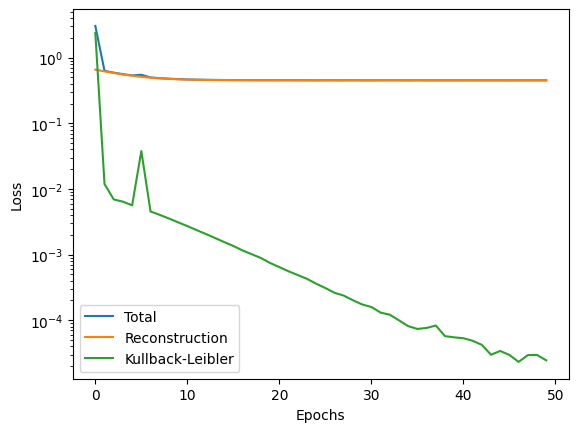

In [27]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

torch.Size([512, 1, 64, 64])


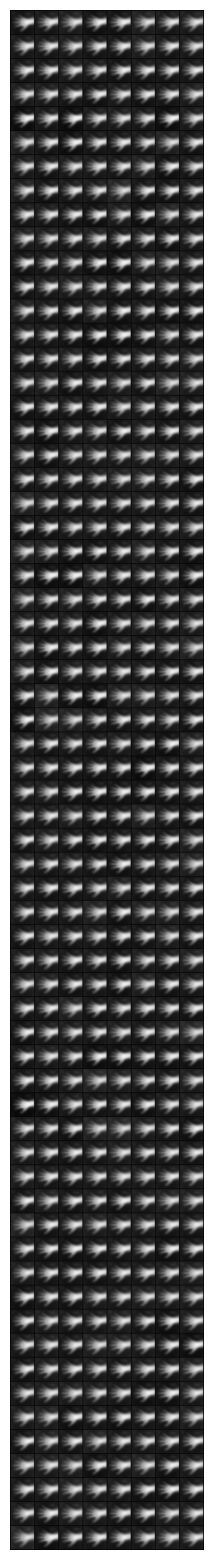

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils
print(fake_image_batch.shape)
p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**3, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**3, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = fake_image_batch.view(-1, 1, 64, 64)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(20, 20))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

Visualization in Latent Space
-----------------------------

invalid escape sequence '\l'
invalid escape sequence '\l'
invalid escape sequence '\l'


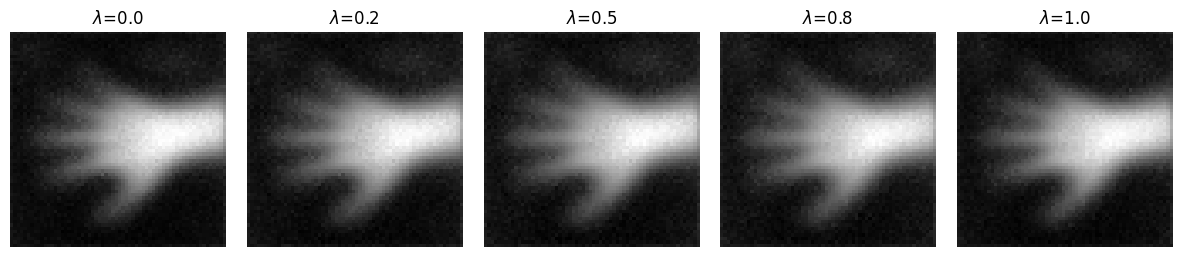

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

def correct_shape(imgs):
  return imgs.view(-1, 28, 28).unsqueeze(1)

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), p, latent_1, latent_2)

    #inter_image = correct_shape(inter_image)
    inter_image = inter_image.view(-1, 1, 64, 64)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()